In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

import sys
sys.path.append("../../../../")

from src.core.control import PrecisionControl
from src.core.control import StorageConfig

from src.core.dimensionless import WavevectorScale, Dimensional, LatticeScale

from src.core.media import PhotorefractiveCrystal
from src.core.eq_coefs import PhotorefractiveCoefs
from src.core.mesh import Mesh2D
from src.core.beams import TwoBeams

from src.fields import NotebookField
from src.fields import Lattice

from src.fields.landscapes.lattices.moire_lattices import double_square

from src.simulators.nls_2d.coupled_eqs import CoupledSimulationBox

from src.analysis.lattice_eigenmodes import SE_SpatialDecomposition

#### Define precision to use in numerical methods.

In [3]:
precision = "single"

periodic_precision = PrecisionControl(precision=precision,
                                       )

aperiodic_precision = PrecisionControl(precision=precision,
                                       )

#### Define Photorefractive crystal parameters

In [4]:
simulation_config = {"Nx": 2*256,
                     "Ny": 2*256,
                     "Nz": 200,
                     "lx": 1e-3,
                     "ly": 1e-3,
                     "lz": 20e-3,
                     }

Isat = 7.5/10.

periodic_crystal_parameters = PhotorefractiveCrystal(n = 2.36,
                                                   electro_optic_coef = 250e-12,
                                                   tension = 400,
                                                   Isat = Isat,#b * 1e-13,
                                                   alpha = 0.,
                                                   Lx = 5e-3,
                                                   Ly = 5e-3,
                                                   Lz = 20e-3,
                                                   )

aperiodic_crystal_parameters = PhotorefractiveCrystal(n = 2.36,
                                                   electro_optic_coef = 250e-12,
                                                   tension = 400,
                                                   Isat = Isat,#b * 1e-13,
                                                   alpha = 0.,
                                                   Lx = 5e-3,
                                                   Ly = 5e-3,
                                                   Lz = 20e-3,
                                                   )

#### Define beam parameters and c (polarization) parameter

In [5]:
sign = -1.

periodic_beam_parameters = TwoBeams(wavelengths = (633e-9, 532e-9),
                             cs = (sign * 1., sign * .1),
                             )

aperiodic_beam_parameters = TwoBeams(wavelengths = (633e-9, 532e-9),
                             cs = (sign * 1., sign * .1),
                             )

#### Define lattice parameters

In [6]:
periodic_theta = np.atan(3/4)
# periodic_theta = np.atan(5/12)
periodic_eta = .5*(.5*np.pi - periodic_theta) + 45*np.pi/180

I = .3
I1 = 30.

periodic_modulation_properties = Lattice(lattice_parameter=(20e-6, 20e-6),
                                               p=(1., 1.),
                                               rotation=(periodic_eta, periodic_theta+periodic_eta),
                                               lattice_method=double_square,
                                               )

aperiodic_theta = np.atan(1/np.sqrt(3))
aperiodic_eta = .5*(.5*np.pi - aperiodic_theta) + 45*np.pi/180
aperiodic_modulation_properties = Lattice(lattice_parameter=(20e-6, 20e-6),
                                          p=(1., 1.),
                                          rotation=(aperiodic_eta, aperiodic_theta+aperiodic_eta),
                                          lattice_method=double_square,
                                          )

#### Choose an adimensionalization

In [7]:
# periodic_adim_method = WavevectorScale(periodic_beam_parameters, periodic_crystal_parameters, periodic_precision)
# aperiodic_adim_method = WavevectorScale(aperiodic_beam_parameters, aperiodic_crystal_parameters, aperiodic_precision)

# periodic_adim_method = Dimensional()
# aperiodic_adim_method = Dimensional()

periodic_adim_method = LatticeScale(lattice_parameters = periodic_modulation_properties,
                                    beam_parameters = periodic_beam_parameters,
                                    crystal_parameters = periodic_crystal_parameters,
                                    )
aperiodic_adim_method = LatticeScale(lattice_parameters = aperiodic_modulation_properties,
                                    beam_parameters = aperiodic_beam_parameters,
                                    crystal_parameters = aperiodic_crystal_parameters,
                                    )

#### Define Schrodinger equation coefficients

In [8]:
periodic_coefs = PhotorefractiveCoefs(periodic_crystal_parameters,
                                    periodic_beam_parameters,
                                    periodic_adim_method,
                                    # invert_energy_scale=True,
                                    )

aperiodic_coefs = PhotorefractiveCoefs(aperiodic_crystal_parameters,
                                    aperiodic_beam_parameters,
                                    aperiodic_adim_method,
                                    # invert_energy_scale=True,
                                    )

periodic_coefs.print_coefs()
aperiodic_coefs.print_coefs()

Kinetic: -0.5, Potential: -12.225322370428243, Absorption: 0.0
Kinetic: -0.5, Potential: -12.225322370428243, Absorption: 0.0


#### Making the meshgrid

In [9]:
periodic_mesh = Mesh2D(simulation_config, periodic_adim_method)
aperiodic_mesh = Mesh2D(simulation_config, aperiodic_adim_method)

#### Generate lattice fields

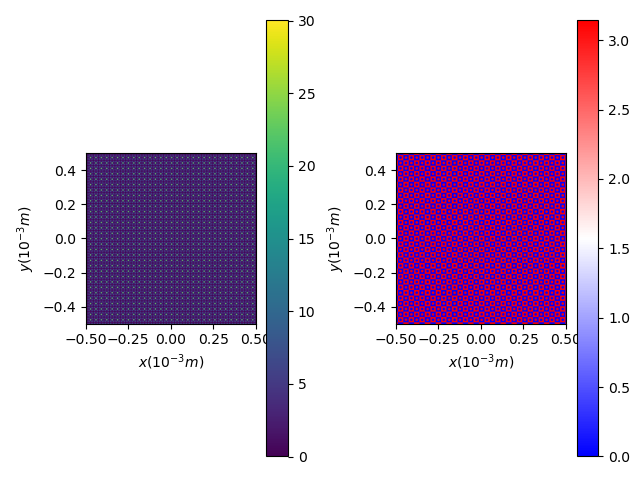

In [10]:
periodic_fields = NotebookField(simulation_config,
                           modulation_config=periodic_modulation_properties,
                           precision_control=periodic_precision,
                           )

periodic_fields.gen_field(periodic_mesh, np.sqrt(I1))

periodic_fields.plot_field()

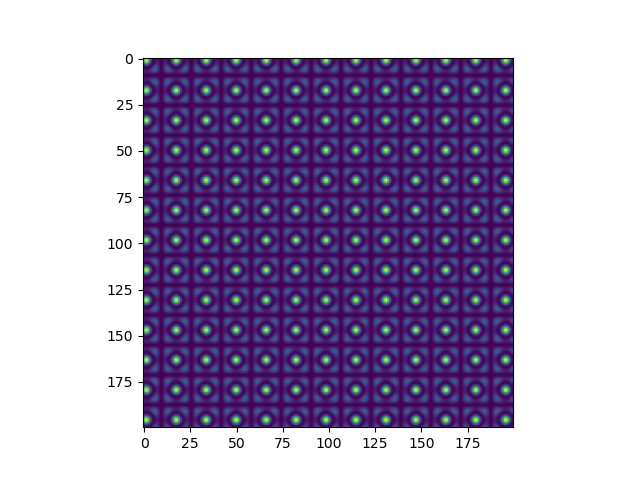

np.float32(3.8309796)

In [11]:
mid_x, mid_y = 128, 128

m = 100

lattice = np.abs(periodic_fields.field[mid_x-m:mid_x+m, mid_y-m:mid_y+m])**2

fig, axs = plt.subplots(1)
axs.imshow(lattice)
fig.show()

np.mean(lattice)

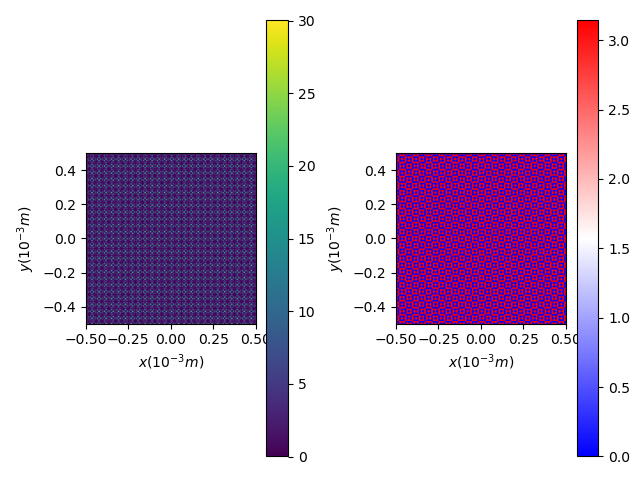

In [12]:
aperiodic_fields = NotebookField(simulation_config,
                           modulation_config=aperiodic_modulation_properties,
                           precision_control=aperiodic_precision,
                           )

aperiodic_fields.gen_field(aperiodic_mesh, np.sqrt(I1))

aperiodic_fields.plot_field()

#### Initialize the Spatial Decomposition class

In [13]:
periodic_lattice_discretization = SE_SpatialDecomposition(periodic_mesh,
                                                   periodic_coefs,
                                                   periodic_precision,
                                                   )

periodic_lattice_discretization.gen_potential(periodic_fields)

In [14]:
aperiodic_lattice_discretization = SE_SpatialDecomposition(aperiodic_mesh,
                                                   aperiodic_coefs,
                                                   aperiodic_precision,
                                                   )

aperiodic_lattice_discretization.gen_potential(aperiodic_fields)

#### Compute eigenvalues

In [15]:
periodic_lattice_eigenvalues, periodic_lattice_eigenvectors = periodic_lattice_discretization.get_eig(n_eigenvectors=50, return_eigenvectors=True)

In [16]:
aperiodic_lattice_eigenvalues, aperiodic_lattice_eigenvectors = aperiodic_lattice_discretization.get_eig(n_eigenvectors=50, return_eigenvectors=True)

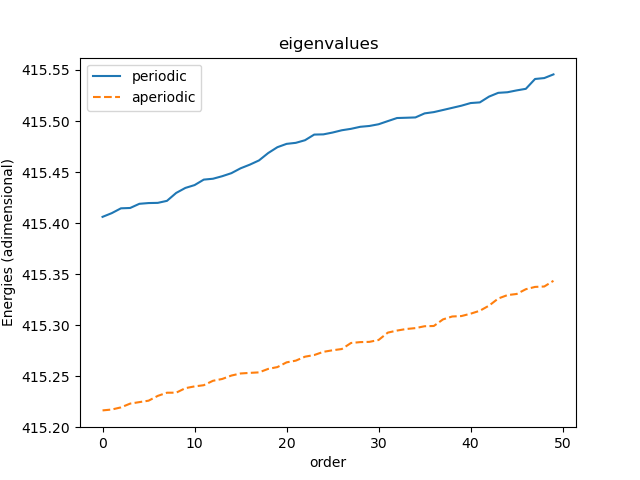

In [17]:
fig, axs = plt.subplots(1)
axs.plot(periodic_lattice_eigenvalues, label="periodic")
axs.plot(aperiodic_lattice_eigenvalues, "--", label="aperiodic")

axs.set_title("eigenvalues")

axs.set_ylabel("Energies (adimensional)")
axs.set_xlabel("order")

axs.legend()
fig.show()

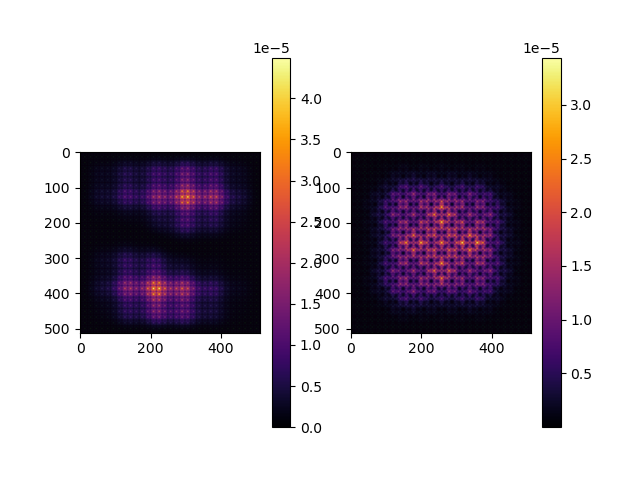

In [18]:
fig, axs = plt.subplots(1, 2)

im = axs[0].imshow(np.abs(periodic_lattice_eigenvectors[:, -2].reshape(simulation_config["Nx"], simulation_config["Nx"]))**2, cmap="inferno")
axs[0].imshow(periodic_fields.get_intensity(), alpha=.1)

fig.colorbar(im, ax=axs[0])

im = axs[1].imshow(np.abs(aperiodic_lattice_eigenvectors[:, -1].reshape(simulation_config["Nx"], simulation_config["Nx"]))**2, cmap="inferno")
axs[1].imshow(aperiodic_fields.get_intensity(), alpha=.1)

fig.colorbar(im, ax=axs[1])

fig.show()

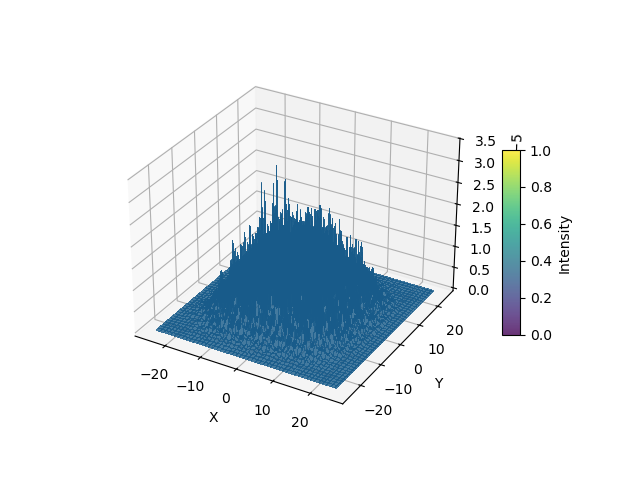

In [19]:
fig, ax = plt.subplots(1, subplot_kw={"projection": "3d"})   

surf = ax.plot_surface(aperiodic_mesh.XX,
                       aperiodic_mesh.YY,
                       np.abs(aperiodic_lattice_eigenvectors[:, -1].reshape(simulation_config["Nx"], simulation_config["Nx"]))**2,
                       linewidth = 0,
                       antialiased = False,
                       alpha = .8,
                    #    rcount=int(field.shape[0]/2),     # draw every row
                    #    ccount=int(field.shape[1]/2),     # draw every column
                       vmin=np.min(np.abs(aperiodic_lattice_eigenvectors[:, -1].reshape(simulation_config["Nx"], simulation_config["Nx"]))**2),
                       vmax=np.max(np.abs(aperiodic_lattice_eigenvectors[:, -1].reshape(simulation_config["Nx"], simulation_config["Nx"]))**2),
                       )

fig.colorbar(surf,
             shrink=0.5,
             aspect=10,
             label='Intensity',
             )

# ax.set_zlim(zlim[0], zlim[1])
        
# Label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Intensity')

fig.show()